.
Regulation of gene expression defines cellular differentiation, development, morphogenesis and the versatility and adaptability of any organism. The most convenient method to understand and compare levels of expression is sequencing mature mRNAs. Next-generation sequencing can provide not only qualitative data but also quantitative - number of reads of particular genes which represents the level of expression.
Having a number of reads we can perform differential expression analysis between experimental groups. In this notebook, we will perform diffential expression (DE) analysis of RNA seq data of mice kidney samples with/without fibrosis disease with DESeq2 package from Bioconductor in R.

The workflow:
1. Load the packages
2. Create a metadata data frame
3. Create DESeq2 object - the model
4. Normalization of reads
5. Unsupervised clustering analysis: hierarchical heat map and principal component analysis (PCA)
6. DE analysis
7. Visualisation of results

In [1]:
#Install DESeq2
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")

# Load library for DESeq2 - differential expression analysis
library(DESeq2)

# Load library for RColorBrewer
library(RColorBrewer)

# Load library for pheatmap
library(pheatmap)

# Load library for tidyverse
library(tidyverse)

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

Installing package(s) 'DESeq2'

also installing the dependencies ‘GenomeInfoDbData’, ‘zlibbioc’, ‘GenomeInfoDb’, ‘XVector’, ‘DelayedArray’, ‘AnnotationDbi’, ‘annotate’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘Biobase’, ‘BiocParallel’, ‘genefilter’, ‘geneplotter’


Old packages: 'actuar', 'adehabitatHR', 'afex', 'AMR', 'apaTables', 'astsa',
  'aweek', 'backports', 'BART', 'bayesplot', 'bayestestR', 'BH',
  'bibliometrix', 'blme', 'BMA', 'breakDown', 'brglm2', 'brio', 'broom',
  'candisc', 'caTools', 'CausalImpact', 'ChainLadder', 'circlize', 'cld2',
  'clusterGeneration', 'coefplot', 'coin', 'colourvalues', 'compareGroups',
  'comprehenr', 'config', 'coronavirus', 'COVID19', 'cowplot', 'cpp11',
  'crosstalk', 'd3Tree', 'data.table', 'DBI', 'Delaporte', 'deldir', 'Deriv',
  'DescTools', 'diffobj', 'directlabels', 'doFuture', 'dplyr', 'drake', 'DT',
  'easyalluvial', 'effectsize', 'embed', 'em

Load a raw count matrix. 'ENSMUSG00...' - geneID and columns represent sample names

In [2]:
#Let's explore the content of raw count matrix
smoc2_rawcounts<-read.csv('/path/fibrosis_smoc2_rawcounts.csv')

# Explore the first six observations of smoc2_rawcounts
head(smoc2_rawcounts)

# Explore the structure of smoc2_rawcounts
str(smoc2_rawcounts)

,X,smoc2_fibrosis1,smoc2_fibrosis4,smoc2_normal1,smoc2_normal3,smoc2_fibrosis3,smoc2_normal4,smoc2_fibrosis2
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSMUSG00000102693,0,0,0,0,0,0,0
2,ENSMUSG00000064842,0,0,0,0,0,0,0
3,ENSMUSG00000051951,72,30,0,3,36,1,51
4,ENSMUSG00000102851,0,0,0,0,0,0,0
5,ENSMUSG00000103377,0,0,1,0,0,0,0
6,ENSMUSG00000104017,0,0,0,0,0,0,0


'data.frame':	47729 obs. of  8 variables:
 $ X              : Factor w/ 47729 levels "ENSMUSG00000000001",..: 41192 18276 15203 41340 41831 42431 41504 30759 41668 41616 ...
 $ smoc2_fibrosis1: int  0 0 72 0 0 0 0 0 0 1 ...
 $ smoc2_fibrosis4: int  0 0 30 0 0 0 0 0 0 1 ...
 $ smoc2_normal1  : int  0 0 0 0 1 0 0 0 0 1 ...
 $ smoc2_normal3  : int  0 0 3 0 0 0 0 0 0 0 ...
 $ smoc2_fibrosis3: int  0 0 36 0 0 0 0 0 0 1 ...
 $ smoc2_normal4  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ smoc2_fibrosis2: int  0 0 51 0 0 0 0 0 0 1 ...


To employ DESeq2 model first we need to make metadata dataframe

In [3]:
# Create genotype vector
genotype <- c('smoc2_oe','smoc2_oe','smoc2_oe','smoc2_oe','smoc2_oe','smoc2_oe','smoc2_oe')

# Create condition vector
condition <- c("fibrosis","fibrosis","fibrosis","fibrosis","normal","normal","normal")

# Create data frame
smoc2_metadata <- data.frame(genotype,condition)

# Assign the row names of the data frame
rownames(smoc2_metadata) <- c('smoc2_fibrosis1','smoc2_fibrosis2','smoc2_fibrosis3','smoc2_fibrosis4','smoc2_normal1','smoc2_normal3','smoc2_normal4')

To assemble statistical model we need to create DESeq2 object. The function - DESeqDataSetFromMatrix has three arguments: raw count matrix, metadata dataframe and design of the formula. In our research DE analysis based on condition: fibrosis/no fibrosis. The formula must contain exact name of the column from metadata

In [4]:
# Use the match() function to reorder the columns of the raw counts
reorder_idx <- match(rownames(smoc2_metadata),colnames(smoc2_rawcounts))

# Reorder the columns of the count data
reordered_smoc2_rawcounts <- smoc2_rawcounts[,reorder_idx]

# Create a DESeq2 object
dds_smoc2 <- DESeqDataSetFromMatrix(countData = reordered_smoc2_rawcounts,
                              colData =  smoc2_metadata,
                              design = ~ condition)

* Count normalization
there are a number of factors other than RNA expression which can influence the number of reads aligning to each gene. A total number of reads can be different from sample to sample. Another issue that longer genes generate more fragments. Since DE analysis compares the same genes between conditions, we do not need to normalize for gene length. However, if you compare expression levels of different genes you will need to account for lengths of the genes. 
* Library composition effect
When adjusting to library size, the composition of the library is also important. A few highly expressed genes can skew many normalization methods that are not resistant to this outliers. DESeq2 is employed median of ratios method of normalization

In [5]:
# Determine the size factors to use for normalization
dds_smoc2 <- estimateSizeFactors(dds_smoc2)

# Extract the normalized counts
smoc2_normalized_counts <- counts(dds_smoc2, normalized=TRUE)

Unsupervised clustering analysis:
1. hierarchical clustering heat maps
2. principal component analysis

log transformation (variance stabilizing transformation - moderates a variance across the mean)

if our replicates are not clustered as expected, we could plot a heatmap with all the metadata and see whether any other factor corresponds to separation. If you see outlier in clustering, you want to check it in PCA too. If you see an outlier in both methods you could investigate this sample more and decide whether to remove it from the analysis.

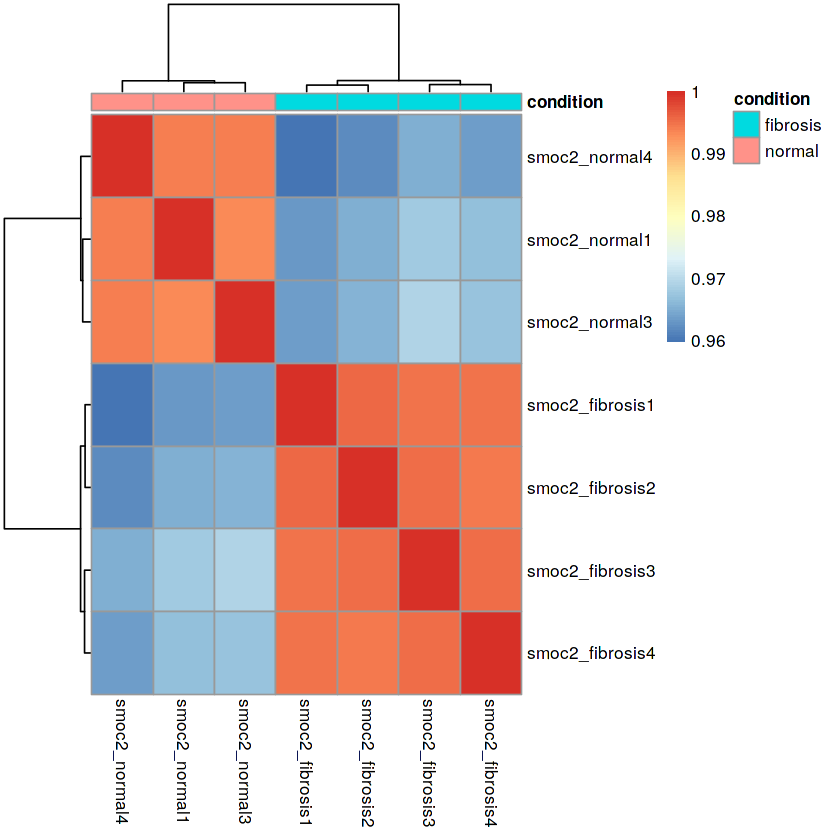

In [6]:
# Transform the normalized counts 
vsd_smoc2 <- vst(dds_smoc2, blind = TRUE)

# Extract the matrix of transformed counts
vsd_mat_smoc2 <- assay(vsd_smoc2)

# Compute the correlation values between samples
vsd_cor_smoc2 <- cor(vsd_mat_smoc2) 

# Plot the heatmap
pheatmap(vsd_cor_smoc2, annotation = select(smoc2_metadata, condition))

Principal component analysis 

We can make clusters by making principal components (PC1 and PC2) - vectors which represent the biggest change in the number of reads of genes across the samples 

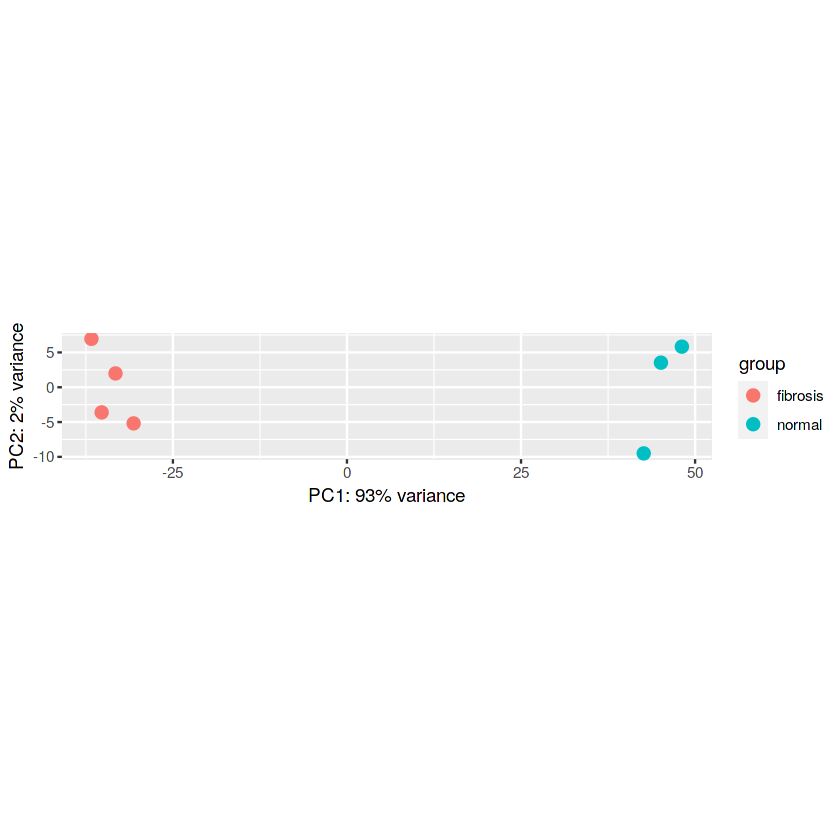

In [7]:
# Transform the normalized counts 
vsd_smoc2 <- vst(dds_smoc2, blind = TRUE)

# Plot the PCA of PC1 and PC2
plotPCA(vsd_smoc2, intgroup='condition')

DE analysis workflow:
1. fitting the raw counts to each gene to DEseq2 negative binomial model and testing for differential expression
2. shrinking log2 fold changes
3. extracting and visualizing the result



1.Modelling raw counts for each gene:
* 1.1 estimate size factors
* 1.2 estimate variation in expression across replicates for each gene
* 1.3 fit to negative binomial model

Variation and Dispersion

* How well our data fit the model?

To model the counts requires the mean and variation in the data 

To explore the variation of the data we will explore the variance in gene expression relative to the mean. Variance is a square of standart deviation, representing how far away the individual samples are from the mean.
For RNAseq data the variance is generally expected to increase with the gene's mean expression.
A measure of the variance for a given mean is described by the metric called dispersion:

Variance=mean+dispersion x mean^2

Plot of dispersion relative to the mean for each gene can be useful to check if our data fit to DEseq model. We expect dispersion values to decrease with increasing mean. With only a few replicates for RNAseq data, gene-wise estimates of dispersion are often inaccurate. DEseq uses information across all genes to determine the most likely estimates for a given mean expression value.

* If dispersions don't decrease with increasing mean this problem can be often explaned by contamination and sample outliers.

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



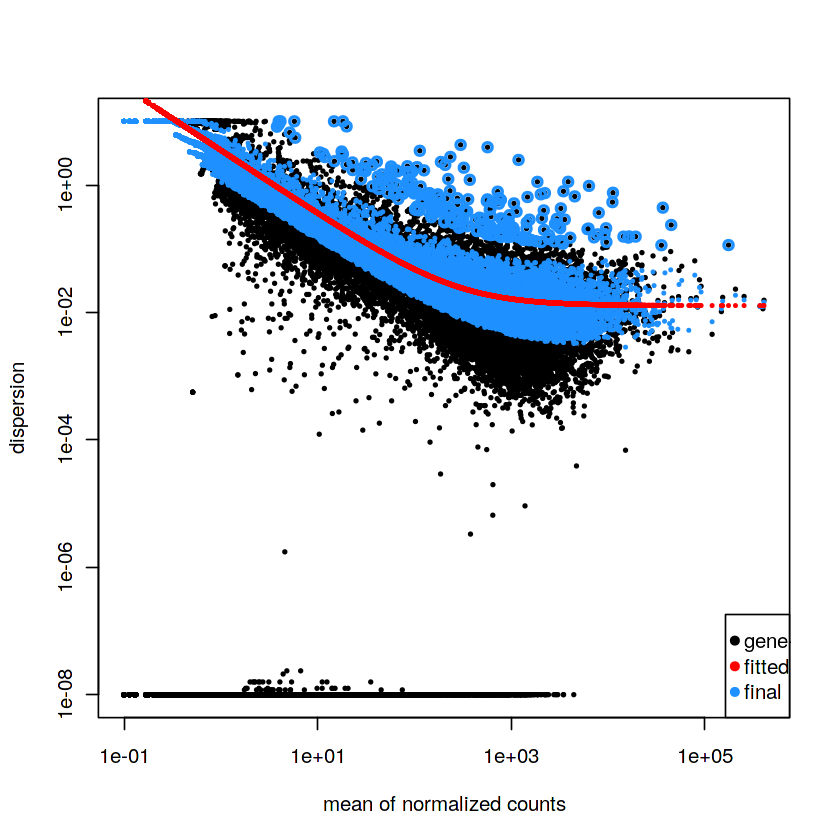

In [8]:
# Plot dispersions
dds_smoc2_<-DESeq(dds_smoc2)
plotDispEsts(dds_smoc2_)

* Fit the data to the model

Negative binomial model

We know that the RNA seq data can be represented well using the negative binomial model as it accounts for the additional variation in the data added by the small number of biological replicates. The formula for the model: 

raw count for gene i sample j ~ NB(size factors ij, normalized counts ij, shrunken dispersion)

For each gene the model uses the log2 normalized counts.

DEseq2 will perform the Wald test for pairwise comparisons. The samples groups for condition are fibrosis and normal. To explore the comparisons of two groups MA plot can be helpful.

Note, for large fold changes, particularly for genes with lower mean count values. These fold changes are likely to be as accurate for genes that have little information associated with them, such as genes with low numbers of counts or high dispersion level. To improve the estimated fold changes we can use log2 fold change shrinkage. For genes with low amount information available, shrinkage uses information from all genes, to generate more likely lower log2 fold change estimates, similar to what we did to dispersion. Shrinkage of log2 foldchanges will not affect the number of differently expressed genes returned, only log2 fold change values. Now, that we have accurate log2 fold changes, we can extract the significant DE genes and perform visualisation of analysis.

In [9]:
# Extract the results of the differential expression analysis
smoc2_res <- results(dds_smoc2_, 
                contrast = c('condition','fibrosis','normal'), 
                alpha = 0.05)

In [10]:
# Shrink the log2 fold change estimates to be more accurate
smoc2_res <- lfcShrink(dds_smoc2_, 
                    contrast =  c('condition', 'fibrosis', 'normal'),
                    res = smoc2_res)

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



The every gene tested with an alpha 0.05, has a chance 5% that the gene is called as DE when it is not, yielding false positive. If we were to test roughly 47000 genes in the raw counts file we would have about 5% or about 2000 genes as false positive. It would be difficult to identify the true positives, or genes that are called DE, when they truly are, from the false. Therefore, multiple test correction is performed by using Benjamini-Hochberg method (BH-method), to adjust p-value for multiple testing and conrol the proportion of false positives relative to true. Using BH-method and an alpha value of 0.05, if we had 1000 genes identified as DE, we would expect 5% of the DE to be false positive or 50 genes. To reduce the number of genes tested DEseq2 automatically filters out genes unlikely to be truly differently expressed prior to testing, such as genes with zero counts across all samples, genes with low mean values across all samples, and genes with extreme count outliers.
To better understand which the genes the results pertain to, we can use annotable package to quickly obtain the genes names for the Ensamble genes IDs using the table of gene annotations for the Grch38 mouse genome build.  

In [11]:
# Extract results
smoc2_res <- results(dds_smoc2_, 
                contrast = c("condition", "fibrosis", "normal"), 
                alpha = 0.05, 
                lfcThreshold = 0.32) #lfcThreshold = 0.32 corresponds to 1.25 fold change

# Shrink the log2 fold changes
smoc2_res <- lfcShrink(dds_smoc2_, 
                    contrast = c("condition", "fibrosis", "normal"), 
                    res = smoc2_res)

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



In [12]:
# Get an overview of the results                    
summary(smoc2_res)

# Save results as a data frame
smoc2_res_all <- data.frame(smoc2_res)

# Subset the results to only return the significant genes with p-adjusted values less than 0.05
smoc2_res_sig <- subset(smoc2_res_all, padj < 0.05)


out of 29556 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3716, 13%
LFC < 0 (down)     : 3322, 11%
outliers [1]       : 15, 0.051%
low counts [2]     : 7207, 24%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Visualisation of results
1. Expression heatmap
2. Volcano plot
3. MA plot

To explore the results, visualizations can be helpful to see a global view of the data, as well as, characteristics of the significant genes. Usually, we expect to see significant genes identified across the range of mean values, which we can plot using the MA plot. If we only see significant genes with high mean values, then it could indicate an issue with our data. The volcano plot helps us to get an idea of the range of fold changes needed to identify significance in our data.

Let's explore our results using MA plots and volcano plots.

Warning message:
“Removed 25395 rows containing missing values (geom_point).”


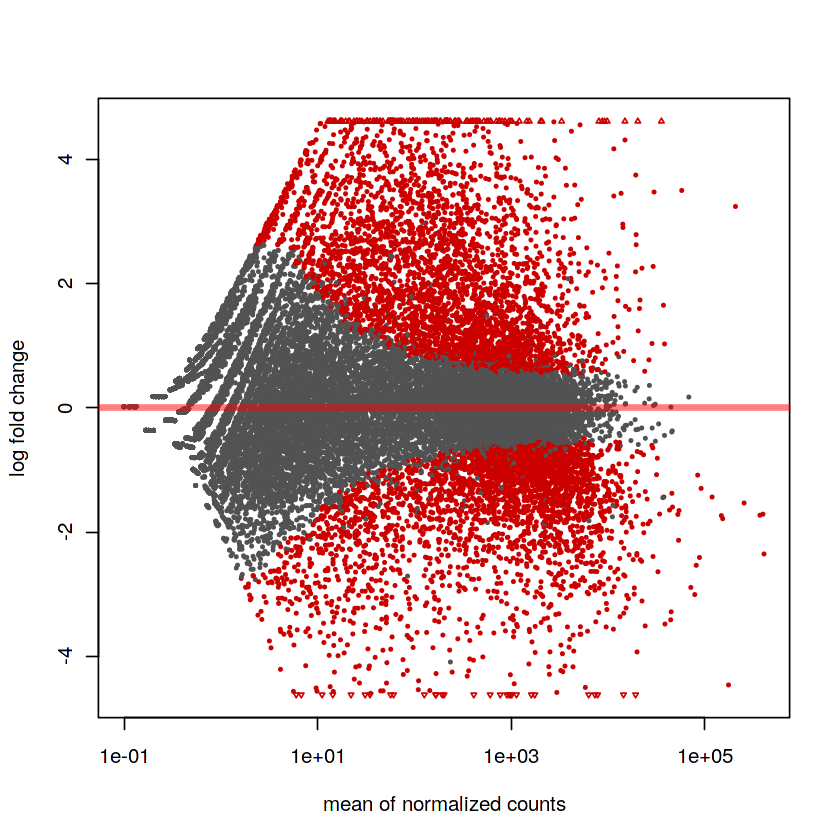

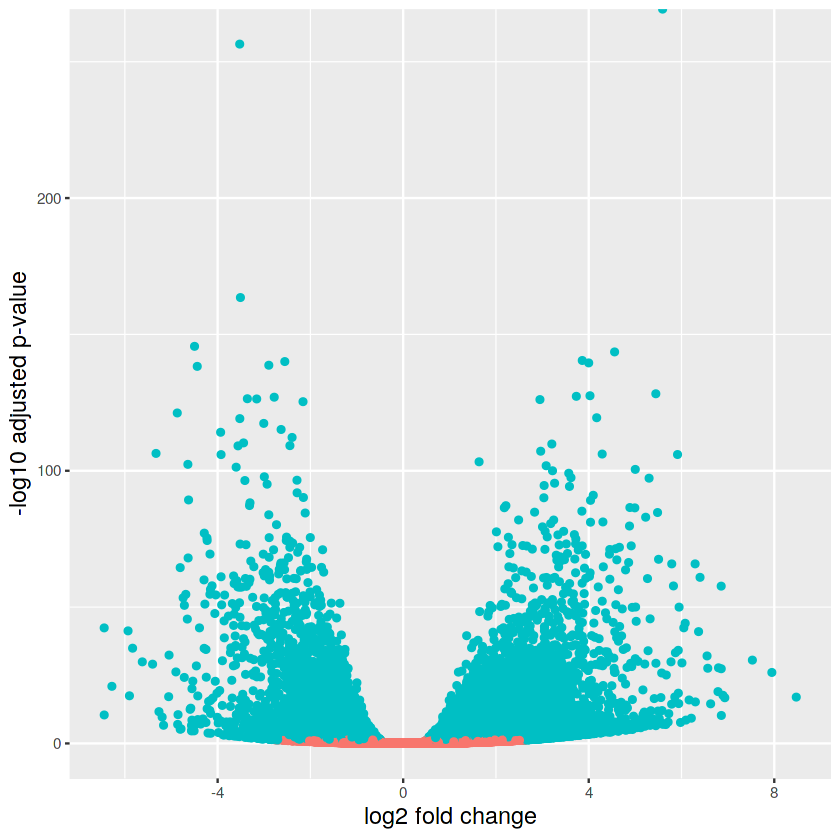

In [13]:
# Create MA plot
plotMA(smoc2_res)

# Generate logical column 
smoc2_res_all <- data.frame(smoc2_res) %>% mutate(threshold = padj < 0.05)
              
# Create the volcano plot
ggplot(smoc2_res_all) + 
        geom_point(aes(x = log2FoldChange, y = -log10(padj), color = threshold)) + 
        xlab("log2 fold change") + 
        ylab("-log10 adjusted p-value") + 
        theme(legend.position = "none", 
              plot.title = element_text(size = rel(1.5), hjust = 0.5), 
              axis.title = element_text(size = rel(1.25)))

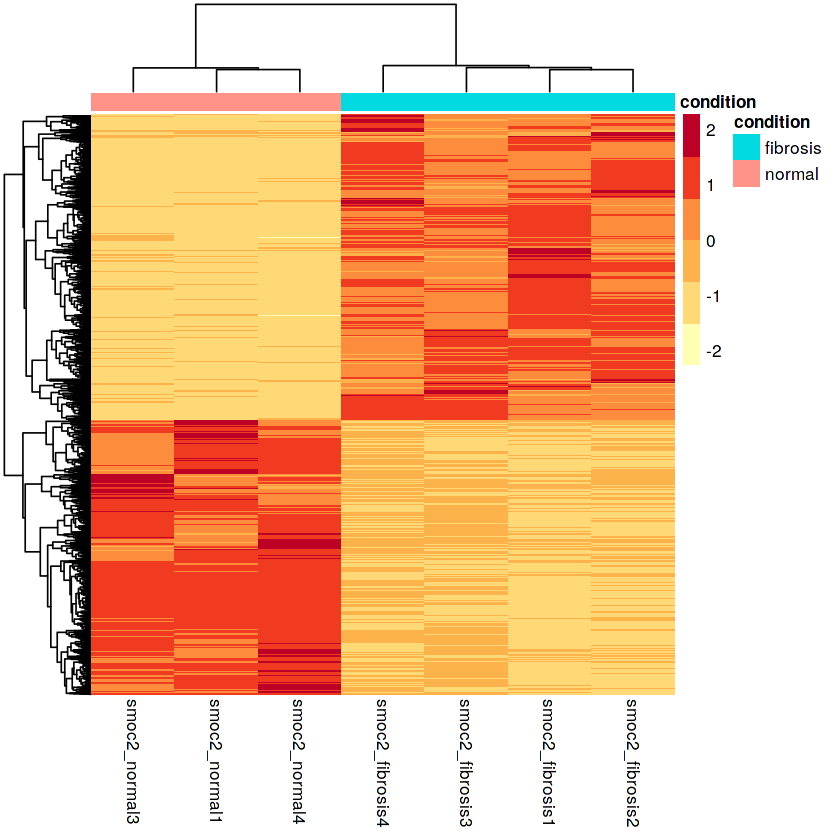

In [14]:
#Transform normalized counts to dataframe
smoc2_normalized_counts<-data.frame(smoc2_normalized_counts)

# Subset normalized counts to significant genes
sig_norm_counts_smoc2 <- smoc2_normalized_counts[rownames(smoc2_res_sig), ]

# Choose heatmap color palette
heat_colors <- brewer.pal(n = 6, name = "YlOrRd")

# Plot heatmap
pheatmap(sig_norm_counts_smoc2, 
         color = heat_colors, 
         cluster_rows = T, 
         show_rownames = F,
         annotation = select(smoc2_metadata, condition), 
         scale = 'row')